In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import heapq
import data, wave_features
import biosppy.signals.eeg as eeg
from detect_peaks import detect_peaks

from scipy.fftpack import fft

#Feature selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# Train/Test splitting
from sklearn.model_selection import train_test_split

# Class Imbalance
from sklearn.utils import resample

# Classification
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier
from sklearn.feature_selection import  SelectKBest, SelectPercentile

# Error
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings('ignore')

In [13]:
train_emg = pd.read_csv('data/train_emg.csv', float_precision='high').drop('Id', axis=1)
train_labels = pd.read_csv('data/train_labels.csv', float_precision='high').drop('Id', axis=1)

train_eeg1 = pd.read_csv('data/train_eeg1.csv', float_precision='high').drop('Id', axis=1)
train_eeg2 = pd.read_csv('data/train_eeg2.csv', float_precision='high').drop('Id', axis=1)


In [56]:
# Load the test set
test_emg = pd.read_csv('data/test_emg.csv', float_precision='high').drop('Id', axis=1)
test_eeg1 = pd.read_csv('data/test_eeg1.csv', float_precision='high').drop('Id', axis=1)
test_eeg2 = pd.read_csv('data/test_eeg2.csv', float_precision='high').drop('Id', axis=1)

train_emg = test_emg
train_eeg1 = test_eeg1
train_eeg2 = test_eeg2

# EMG feature extraction

In [14]:
train_labels['y'].value_counts()
train_labels.head(5)

,y
0,2
1,2
2,2
3,2
4,2


## General features

In [57]:
EMG_features = pd.DataFrame(0, index=np.arange(len(train_emg)), columns=['EMG_mean', 'EMG_median', 'EMG_std', 'EMG_max',
                                                                   'EMG_min', 'EMG_sum', 'EMG_simps'])

EMG_features['EMG_mean'] = train_emg.mean(axis=1)
EMG_features['EMG_median'] = train_emg.median(axis=1)
EMG_features['EMG_std'] = train_emg.std(axis=1)
EMG_features['EMG_max'] = train_emg.max(axis=1)
EMG_features['EMG_min'] = train_emg.min(axis=1)
EMG_features['EMG_sum'] = train_emg.sum(axis=1)
EMG_features['EMG_simps'] = scipy.integrate.simps(train_emg**2)
train_emg['x513'] = train_emg.mean(axis=1)
EMG_features['EMG_romb'] = scipy.integrate.romb(train_emg**2)
train_emg = train_emg.drop('x513', axis=1)


In [58]:
EEG_features = pd.DataFrame(0, index=np.arange(len(train_eeg1)), columns=['EEG1_mean'])
EEG_features['EEG1_mean'] = train_eeg1.mean(axis=1)
EEG_features['EEG1_median'] = train_eeg1.median(axis=1)
EEG_features['EEG1_std'] = train_eeg1.std(axis=1)
EEG_features['EEG1_max'] = train_eeg1.max(axis=1)
EEG_features['EEG1_min'] = train_eeg1.min(axis=1)
EEG_features['EEG1_sum'] = train_eeg1.sum(axis=1)
EEG_features['EEG1_simps'] = scipy.integrate.simps(train_eeg1**2)
EEG_features['EEG2_mean'] = train_eeg2.mean(axis=1)
EEG_features['EEG2_median'] = train_eeg2.median(axis=1)
EEG_features['EEG2_std'] = train_eeg2.std(axis=1)
EEG_features['EEG2_max'] = train_eeg2.max(axis=1)
EEG_features['EEG2_min'] = train_eeg2.min(axis=1)
EEG_features['EEG2_sum'] = train_eeg2.sum(axis=1)
EEG_features['EEG2_simps'] = scipy.integrate.simps(train_eeg2**2)


In [17]:
# Normalization constants (only for training sets)
EMG_mean = EMG_features.mean(axis=0)
EMG_std = EMG_features.std(axis=0)
EEG_mean = EEG_features.mean(axis=0)
EEG_std = EEG_features.std(axis=0)

In [59]:
# Normalization
EMG_features = (EMG_features - EMG_mean) / EMG_std
EEG_features = (EEG_features - EEG_mean) / EEG_std

## EEG Stochastic Signal Analysis 

In [19]:
print(train_eeg1.shape)
t_n = 4
N = train_eeg1.shape[1]
T = t_n / N
f_s = 1/T


(64800, 512)


In [ ]:
# Fast Fourier Transform
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values = fft(y_values, axis=1)
    fft_values = 2.0/N *np.abs(fft_values)
    
    return f_values, fft_values
f_values, fft_values = get_fft_values(train_eeg1, T, N, f_s)


In [ ]:
plt.plot(f_values, fft_values[4][:N//2], linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of class 2", fontsize=16)
#plt.show()

plt.plot(f_values, fft_values[6][:N//2], linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of class 3", fontsize=16)
#plt.show()

plt.plot(f_values, fft_values[33][:N//2], linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of class 1", fontsize=16)
#plt.show()

In [ ]:
# Choosing the n argmax
n = 2
peaks = np.argpartition(fft_values[0][:N//2], -n)[-n:]
#amp = np.max(fft_values[0][:N//2], -n)[-n:]

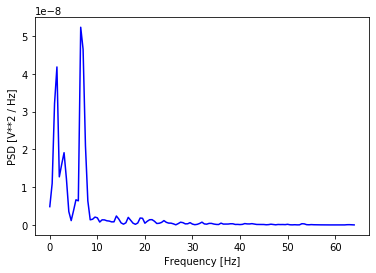

In [20]:
# Power Spectral Density
from scipy.signal import welch
 
def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, axis=1, fs=f_s)
    return f_values, psd_values
 

f_values, psd_values = get_psd_values(train_eeg1, T, N, f_s)
 
plt.plot(f_values, psd_values[33], linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2 / Hz]')
plt.show()

In [ ]:
# Correlation 
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = np.zeros([y_values.shape[0],y_values.shape[1]])
    for i in range(0,y_values.shape[0]):
        autocorr_values[i] = autocorr(y_values.iloc[i])
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values
 
 
t_values, autocorr_values = get_autocorr_values(train_eeg1, T, N, f_s)
 
plt.plot(t_values, autocorr_values[0], linestyle='-', color='blue')
plt.xlabel('time delay [s]')
plt.ylabel('Autocorrelation amplitude')
plt.show()

In [ ]:
from detect_peaks import detect_peaks

def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [1 * kk for kk in range(0,len(y_values))]
    return x_values, y_values

####

labels = ['x-component','y-component', 'z-component' ]
colors = ['r', 'b', 'g']
suptitle = "Different signals for the activity: {}"

xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Value'],['FFT'], ['PSD'], ['Autocorr']]

list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]

signal_no = 0
signals = train_eeg1
label = train_labels.iloc[signal_no]
activity_name = [label]

f, axarr = plt.subplots(nrows=4, ncols=1, figsize=(12,12))
f.suptitle(suptitle.format(activity_name), fontsize=16)

for row_no in range(0,4):
    for comp_no in range(0,1):
        col_no = comp_no //1
        plot_no = comp_no % 1
        color = colors[plot_no]
        label = labels[plot_no]

        axtitle  = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = list_functions[row_no]

        ax = axarr[row_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        print(row_no)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)
        
        if row_no == 0:
            
            x_values, y_values = [1 * kk for kk in range(0,len(signals))], signals
        if row_no == 1:
            x_values, y_values = get_fft_values(train_eeg1, T, N, f_s)
            y_values = y_values[0][:N//2]
        if row_no == 2:
            x_values, y_values = get_psd_values(train_eeg1, T, N, f_s)
            y_values = y_values[0]
        if row_no == 3:
            x_values, y_values = get_autocorr_values(train_eeg1, T, N, f_s)
            y_values = y_values[0]
            
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
        if row_no > 0:
            max_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = detect_peaks(y_values, mph=max_peak_height)
            ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

In [60]:
# Extracting the features EEG1

## FFT
#x_valuesf1, y_valuesf1 = get_fft_values(train_eeg1, T, N, f_s)
#max_peak_heightf1 = 0.1 * np.nanmax(y_valuesf1, axis=1)

## PSD
x_valuesp1, y_valuesp1 = get_psd_values(train_eeg1, T, N, f_s)
max_peak_heightp1 = 0.1 * np.nanmax(y_valuesp1, axis=1)
num_peaksp1 = np.zeros(max_peak_heightp1.shape[0])

#indices_peaksf1 = []
indices_peaksp1 = []

for i in range(0, max_peak_heightp1.shape[0]):
    #fft_ind = detect_peaks(y_valuesf1[i][:N//2], mph=max_peak_heightf1[i])
    psd_ind = detect_peaks(y_valuesp1[i], mph=max_peak_heightp1[i])
    #indices_peaksf1.append(pd.concat([pd.DataFrame(fft_ind[:2]), pd.DataFrame(psd_ind[:2])], axis=1))
    num_peaksp1[i] = len(psd_ind)
    indices_peaksp1.append(psd_ind[:1])

In [61]:
# Extracting the features EEG2

## FFT
#x_valuesf2, y_valuesf2 = get_fft_values(train_eeg2, T, N, f_s)
#max_peak_heightf2 = 0.1 * np.nanmax(y_valuesf2, axis=1)

## PSD
x_valuesp2, y_valuesp2 = get_psd_values(train_eeg2, T, N, f_s)
max_peak_heightp2 = 0.1 * np.nanmax(y_valuesp2, axis=1)
num_peaksp2 = np.zeros(max_peak_heightp2.shape[0])

#indices_peaksf2 = []
indices_peaksp2 = []
for i in range(0, max_peak_heightp2.shape[0]):
    #fft_ind = detect_peaks(y_valuesf2[i][:N//2], mph=max_peak_heightf2[i])
    psd_ind = detect_peaks(y_valuesp2[i], mph=max_peak_heightp2[i])
    #indices_peaksf2.append(pd.concat([pd.DataFrame(fft_ind[:2]), pd.DataFrame(psd_ind[:2])], axis=1))
    indices_peaksp2.append(psd_ind[:1])
    num_peaksp2[i] = len(psd_ind)

In [32]:
# Normalization constants (only for training set)
p2_mean =max_peak_heightp2.mean(axis=0)
p2_std = max_peak_heightp2.std(axis=0)
p1_mean =max_peak_heightp1.mean(axis=0)
p1_std = max_peak_heightp1.std(axis=0)



In [62]:
max_peak_heightp2 = (max_peak_heightp2-p2_mean)/p2_std
max_peak_heightp1 = (max_peak_heightp1-p1_mean)/p1_std

In [77]:
wave_eeg1 = pd.read_csv('out/wave_features_eeg1_size1.csv', float_precision='high')
wave_eeg2 = pd.read_csv('out/wave_features_eeg2_size1.csv', float_precision='high')

In [85]:
wave_eeg1 = pd.read_csv('out/wave_features_eeg1_size1_test.csv', float_precision='high')
wave_eeg2 = pd.read_csv('out/wave_features_eeg2_size1_test.csv', float_precision='high')

In [86]:
# Normalize wave files
wave_eeg1 = (wave_eeg1-wave_eeg1_mean)/wave_eeg1_std
wave_eeg2 = (wave_eeg2-wave_eeg2_mean)/wave_eeg2_std

In [79]:
wave_eeg1_mean = wave_eeg1.mean(axis=0)
wave_eeg2_mean = wave_eeg2.mean(axis=0)
wave_eeg1_std = wave_eeg1.std(axis=0)
wave_eeg2_std = wave_eeg2.std(axis=0)

In [53]:
# Wave forms
s = 1
wave_features1 = wave_features.get_wave_features2(data.load_test_eeg1(subjects=[0,1], do_filter=True),size=s)
wave_features2 = wave_features.get_wave_features2(data.load_test_eeg2(subjects=[0,1], do_filter=True),size=s)
print(wave_features1.shape)
#X_val = get_wave_features2(data.load_train_eeg1(subjects=[1], do_filter=True),
#y_val = data.load_train_labels([1])

(43200, 35)


In [54]:
wave_features1 = pd.DataFrame(wave_features1) 
wave_features1.to_csv('out/wave_features_eeg1_size1_test.csv')
wave_features2 = pd.DataFrame(wave_features2) 
wave_features2.to_csv('out/wave_features_eeg2_size1_test.csv')

In [96]:
SLEEP_features.shape

(43200, 100)

In [95]:
# without wave files 
#SLEEP_features = pd.concat([EMG_features, EEG_features, pd.DataFrame(indices_peaksp2), 
#                            pd.DataFrame(indices_peaksp1), pd.DataFrame(max_peak_heightp2), 
#                            pd.DataFrame(max_peak_heightp1),pd.DataFrame(num_peaksp2), 
#                            pd.DataFrame(num_peaksp1)], axis=1)
#
# with wave files
SLEEP_features = pd.concat([EMG_features, EEG_features, pd.DataFrame(indices_peaksp2), 
                            pd.DataFrame(indices_peaksp1), pd.DataFrame(max_peak_heightp2), 
                            pd.DataFrame(max_peak_heightp1),pd.DataFrame(num_peaksp2), 
                            pd.DataFrame(num_peaksp1),
                            wave_eeg1,wave_eeg2], axis=1)

#X_train = SLEEP_features[:43200]
#y_train = train_labels['y'][:43200]
#X_test = SLEEP_features[-21600:]
#y_test = train_labels['y'][-21600:]
#X_train, X_test, y_train, y_test = train_test_split(SLEEP_features, train_labels['y'], test_size=0.2)
#y_train_init = np.where(y_train != 1, 2.0, 1.0)
#y_test_init = np.where(y_test != 1, 2.0, 1.0)

#print(y_train.shape)
#X_train.shape

In [48]:
clf = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, tol=0.001, cache_size=200, max_iter=-1, random_state=None)
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)

In [49]:
BMAC = balanced_accuracy_score(Y_test, y_pred)

print(BMAC)

0.8756498402745118


In [ ]:
# Cross-validation of the results
cv_score = cross_val_score(clf, SLEEP_features, train_labels['y'] , cv=4, scoring=('balanced_accuracy'))
print('The mean cross-validation score is : ',cv_score.mean())
print(cv_score)

In [97]:
# dealing with NaN values
SLEEP_features.isnull()

,EMG_mean,EMG_median,EMG_std,EMG_max,EMG_min,EMG_sum,EMG_simps,EMG_romb,EEG1_mean,EEG1_median,...,25,26,27,28,29,30,31,32,33,34
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43195,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
43196,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
43197,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
43198,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [102]:
#y_pred = clf.predict(SLEEP_features)
y_final_pred = pd.read_csv('data/sample.csv')
y_final_pred['y'] = pd.DataFrame(y_pred) 
y_final_pred.to_csv('out/with_waves.csv')

In [103]:
y_final_pred.head()

,Id,y
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
